In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()
%matplotlib inline

import nengo
from nengo.utils.numpy import rmse
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab

In [6]:
from collections import namedtuple, OrderedDict

In [7]:
def choose_encoders(n_neurons: int, dimensions: int, encoder_proportion: float, mean_fan1, mean_fan2):
    encoders = np.zeros((n_neurons, dimensions))

    fan1_end = int(n_neurons * encoder_proportion)

    for n_i in range(fan1_end):
        encoders[n_i] = mean_fan1 + np.random.normal(size=dimensions)*0.1

    for n_i in range(fan1_end, n_neurons):
        encoders[n_i] = mean_fan2 + np.random.normal(size=dimensions)*0.1
    
    return encoders

In [8]:
dimensions = 64
n_neurons = 1000
seed = 8
p_fan = 0.85

Stim = namedtuple("Stim", ['fan_num', 'targ', 'vecs'])

In [9]:
vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(16, 16, dimensions, seed, norm=True)
mean_fan1 = np.mean(fan1_pair_vecs, axis=0)
mean_fan2 = np.mean(fan2_pair_vecs, axis=0)

stim_vecs = {"fan1": Stim(1, True, np.array(fan1_pair_vecs)),
             "fan2": Stim(2, True, np.array(fan2_pair_vecs)),
             "foil1": Stim(1, False, np.array(foil1_pair_vecs)),
             "foil2": Stim(2, False, np.array(foil2_pair_vecs))}

In [10]:
encoders = choose_encoders(n_neurons, dimensions, p_fan, mean_fan1, mean_fan2)

# Show the general trend

In [11]:
with nengo.Network() as model:
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=encoders)
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                                                                                 


In [13]:
df_list = []

for key, obj in stim_vecs.items():
    _, act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=obj.vecs)

    flat_act = list(act.flatten())
    resp = [obj.fan_num] * len(flat_act)
    targ = [obj.targ] * len(flat_act)
    df_list.append(pd.DataFrame({"act": flat_act, "resp": resp, "targ": targ}))

act_df = pd.concat(df_list)

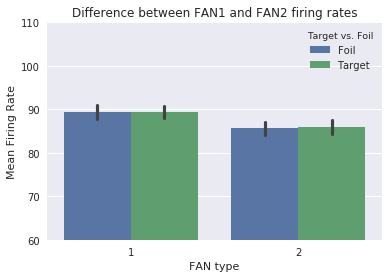

In [23]:
ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)
ax.set_ylim((60, 110))

ax.set_title("Difference between FAN1 and FAN2 firing rates")
ax.set_ylabel("Mean Firing Rate")
ax.set_xlabel("FAN type")

ax.legend_.set_title("Target vs. Foil")
new_labels = ("Foil", "Target")
for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)